## Logistic Regression for Modelling US Bank Defaults from FDIC Call Report data
___

Simple implementation of a logistic regression model with log-likelihood loss function in tensorflow, applied to a downsampled dataset of FDIC call report data for binary US Bank Default classification. 

Data provided by Igor Harpin in Coursera: ML and RL in Finance; part of assessed projects in subcourse 1.


Start by importing the already split training and test datasets:

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")

df_train = pd.read_hdf('df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('df_test_FDIC_defaults_1Y.h5', key='df')


Declare lists of relevant features for 
- indivudal bank KPIs
- macro economic outlook

In [2]:
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()


In [34]:
df_train[MEV_cols].corr()


,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


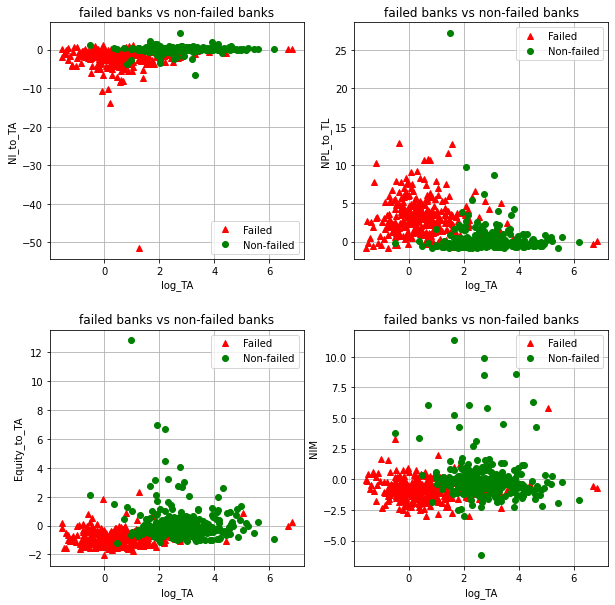

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])

That looks very favourable for our classification - which definetly can partly be attributed to the way in which the downsampling was conducted. The total dataset contained 9500 banks, of which only ~500 failed. The dataset was then downsampled to include the 500 failed banks and the 500 largest (by total assets) non-failed banks. Unsurprisingly, the 500 largest successful banks all show relatively distinct features to most failed banks.

Note the two failed banks that completely ignore this trend and have the highest and second highest total assets (log_TA > 6) - this can only be connected to 2008. Let's check:

In [36]:
df_train[(df_train['log_TA'] > 6) & (df_train['defaulter'] == 1) ]


,,Financial Institution Name,Institution Name,total_assets,defaulter,Failure / Assistance,log_TA,NI_to_TA,Equity_to_TA,NPL_to_TL,REO_to_TA,...,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,default_within_1Y,Failure,max_total_assets,num_records,non_defaulter,const
IDRSSD,date,,,,,,,,,,,,,,,,,,,,,
476810,2015-06-30,"CITIBANK, N.A.",NaN,1.336201e+09,1.0,NaN,6.697813,0.127197,-0.026715,-0.271906,-0.364811,...,0.000112,0.082696,-0.547780,-0.203658,0.0,NaN,1.377279e+09,60.0,0.0,1
480228,2015-06-30,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,1.606232e+09,1.0,NaN,6.833548,0.219338,0.221892,0.115699,-0.332458,...,-0.002470,0.141715,-0.968025,-0.139364,0.0,NaN,1.639305e+09,60.0,0.0,1


and indeed the TARP state intervention of 2009 is what we noted here.

Let's proceed and create the train and test datasets:

In [38]:
cols = state_cols + MEV_cols    # use both individual KPIs and macro economic features

# create feature datasets
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add a constant bias feature
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# create the predictor datasets
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

print('Number of training samples:', y_trainTf.shape[0])
print('Number of test samples:', y_testTf.shape[0])


Number of training samples: 641
Number of test samples: 331


and create two auxiliary functions for resetting the tensorflow graph and random batch creation:

In [11]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

We now define the tensorflow graph, the loss function and the optimizer:

In [7]:
import tensorflow as tf

reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)


X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, name="theta")

Y_hat = tf.nn.sigmoid(tf.matmul(X, theta)) 

cost = tf.nn.sigmoid_cross_entropy_with_logits( 
                    logits = Y_hat, labels = y) 

optimizer = tf.train.GradientDescentOptimizer( 
         learning_rate = learning_rate).minimize(cost)

y_proba = 1 / (1 + tf.exp(-tf.matmul(X, theta)))                 

init = tf.global_variables_initializer()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


And now initialize and run the tensorflow session, training on the randomly batched training set and evaluating on the test set:   

In [12]:
n_epochs = 1001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            Xt, yt = random_batch(X_trainTf, y_trainTf, batch_size = batch_size)
            sess.run(optimizer, feed_dict = {X : Xt, y : yt})
            
    y_proba_val = sess.run(y_proba, feed_dict = {X: X_testTf})
    y_pred = (y_proba_val >= 0.5)

and finally simply using sklearn's metrics evaluate the classifier performance:

precision: 0.98089 
recall: 0.95652 
AUC score = 0.98608 
roc_auc = 0.98608 
KS_test = 0.94509 


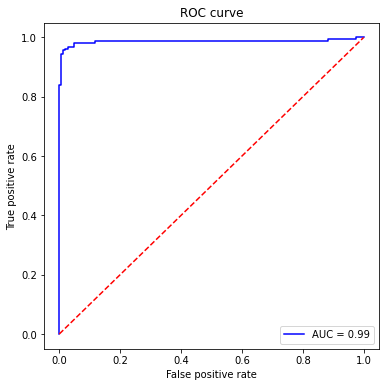

In [33]:
import sklearn.metrics as metrics

precision = metrics.precision_score(y_testTf, y_pred)
recall = metrics.recall_score(y_testTf, y_pred)
auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ks = np.max(tpr - fpr)

plt.figure(figsize = (6,6))
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

print('precision: %0.5f ' % precision)
print('recall: %0.5f ' % recall)
print('AUC score = %0.5f ' % auc_score)
print('roc_auc = %0.5f ' % roc_auc)
print('KS_test = %0.5f ' % ks)